In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [3]:
from src.gpu_info.gpu_info import get_gpu_info

In [4]:
get_gpu_info(0)

Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/gpu_info2/build.ninja...
Building extension module gpu_info2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gpu_info2...


{'name': 'NVIDIA GeForce RTX 4060 Laptop GPU',
 'luid': '',
 'luidDeviceNodeMask': 0,
 'totalGlobalMem': 8325824512,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'memPitch': 2147483647,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim[0]': 1024,
 'maxThreadsDim[1]': 1024,
 'maxThreadsDim[2]': 64,
 'maxGridSize[0]': 2147483647,
 'maxGridSize[1]': 65535,
 'maxGridSize[2]': 65535,
 'clockRate': 2250000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 9,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'deviceOverlap': 1,
 'multiProcessorCount': 24,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'maxTexture2D': 131072,
 'maxTexture2DMipmap': 32768,
 'maxTexture2DLinear': 131072,
 'maxTexture2DGather': 32768,
 'maxTexture3D': 16384,
 'maxTexture3DAlt': 8192,
 'maxTextureCubemap': 32768,
 'maxTexture1DLayered': 32768,
 'maxTextu

### define inputs

In [5]:
S = 64 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 32 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_C_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_C_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_C_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.03671073913574219
fw n match: False, max diff: 0.014554262161254883
fw m match: False, max diff: 0.013850808143615723
fw D match: False, max diff: 0.011723697185516357
---------------------------------
bw dQs match: False, max diff: 0.07791519165039062
bw dKs match: False, max diff: 0.05619549751281738
bw dVs match: False, max diff: 0.03302645683288574
bw dIgs match: False, max diff: 0.12425804138183594
bw dFgs match: False, max diff: 0.07966279983520508
bw delta_D match: False, max diff: 0.33443450927734375
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.7851886749267578
fw n match: False, max diff: 0.18564105033874512
fw m match: False, max diff: 0.11692214012145996
fw D match: False, max diff: 0.11114472150802612
---------------------------------
bw dQs match: False, max diff: 0.7875323295593262
bw dKs match: False, max diff: 0.6698460578918457
bw dVs match: False, max diff: 0.7707123756408691
bw dIgs match: F

In [13]:
(matD_pt)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1548e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3850e-01, 1.2679e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 8.0032e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4947e-02, 3.1993e-02, 2.5233e-01, 6.2876e-01, 5.0321e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2326e-03, 2.9594e-03, 2.3340e-02, 5.8161e-02, 4.6547e-02, 9.2500e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.7981e-03, 2.1923e-02, 1.7546e-02, 3.486

In [14]:
(matD_pt_half)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1504e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3855e-01, 1.2683e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5542e-02, 5.0873e-02, 4.0137e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5664e-02, 5.0873e-02, 4.0137e-01, 1.0000e+00, 7.9932e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.5034e-02, 3.2013e-02, 2.5293e-01, 6.3086e-01, 5.0391e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2330e-03, 2.9545e-03, 2.3376e-02, 5.8441e-02, 4.6600e-02, 9.2468e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2178e-03, 1.1177e-03, 8.8196e-03, 2.1881e-02, 1.7471e-02, 3.476

In [15]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

In [16]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -4.3637e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 5.0411e-05,  3.8266e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.8959e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.3111e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00, -1.0080e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.6937e-05,  1.9595e-05,  6.0183e-04,  2.0962e-03,  6.9177e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.3574e-07, -4.9016e-06,  3.6132e-05,  2.8056e-04,  5.2996e-05, -3.1762e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [17]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [18]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [19]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [20]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.7852, device='cuda:0'), tensor(0.0334, device='cuda:0'))

### match directly

In [21]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 33408
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 55168
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In BW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [22]:
# hs_cu = hs_pt
# n_cu = n_pt
# m_cu = m_pt
# matD_cu = matD_pt
# dQs_cu = dQs_pt
# dKs_cu = dKs_pt
# dVs_cu = dVs_pt
# dIgs_cu = dIgs_pt
# dFgs_cu = dFgs_pt
# matC_cu = matD_pt

In [23]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 17024
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 27904
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In BW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [24]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 17024
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 27904
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In BW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [25]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.719329833984375e-05
fw n match: True, max diff: 9.417533874511719e-06
fw m match: True, max diff: 4.5299530029296875e-06
fw D match: True, max diff: 7.62939453125e-06
---------------------------------
bw dQs match: True, max diff: 0.00028228759765625
bw dKs match: True, max diff: 0.000301361083984375
bw dVs match: True, max diff: 3.7670135498046875e-05
bw dIgs match: True, max diff: 0.00012230873107910156
bw dFgs match: True, max diff: 2.86102294921875e-05
====== Half ======
fw hs match: False, max diff: 0.012780904769897461
fw n match: False, max diff: 0.00409388542175293
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 0.01611328125
---------------------------------
bw dQs match: False, max diff: 0.03619194030761719
bw dKs match: False, max diff: 0.03984260559082031
bw dVs match: False, max diff: 0.012690067291259766
bw dIgs match: False, max diff: 0.034941673278808594
bw dFgs m

In [26]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

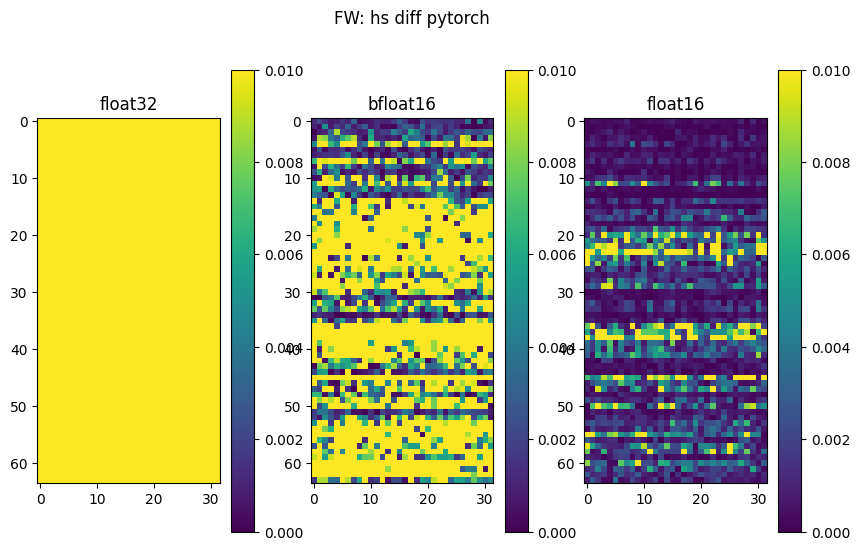

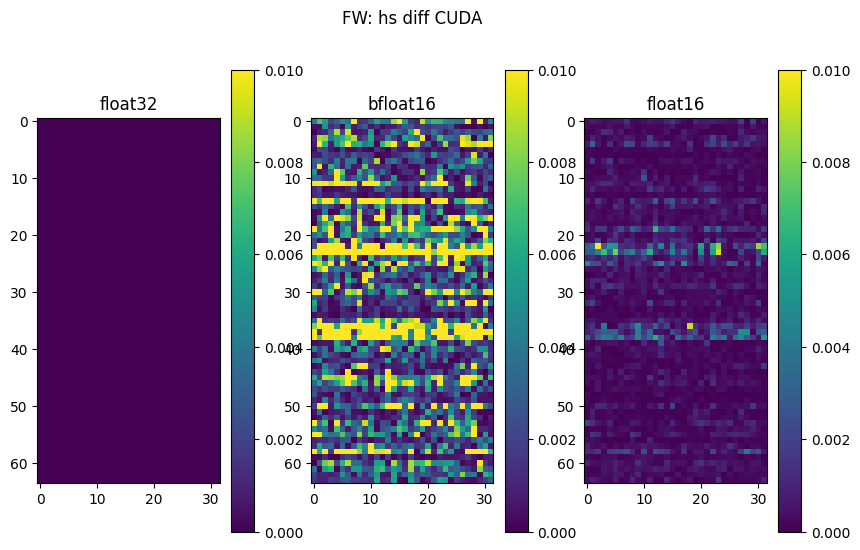

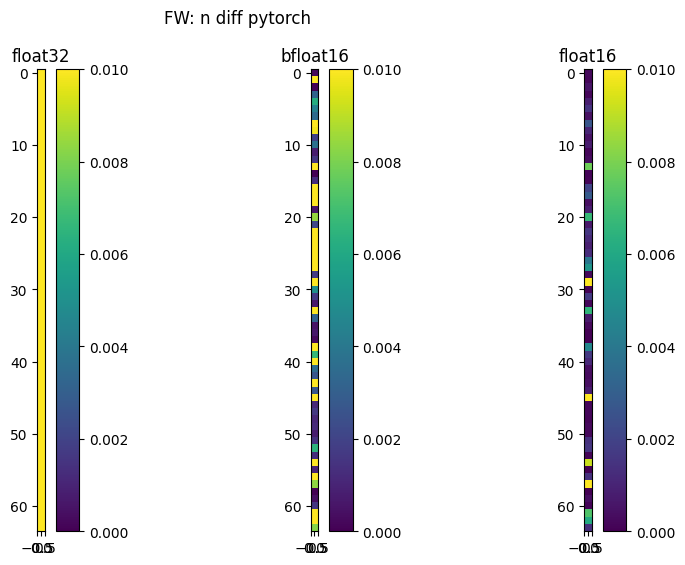

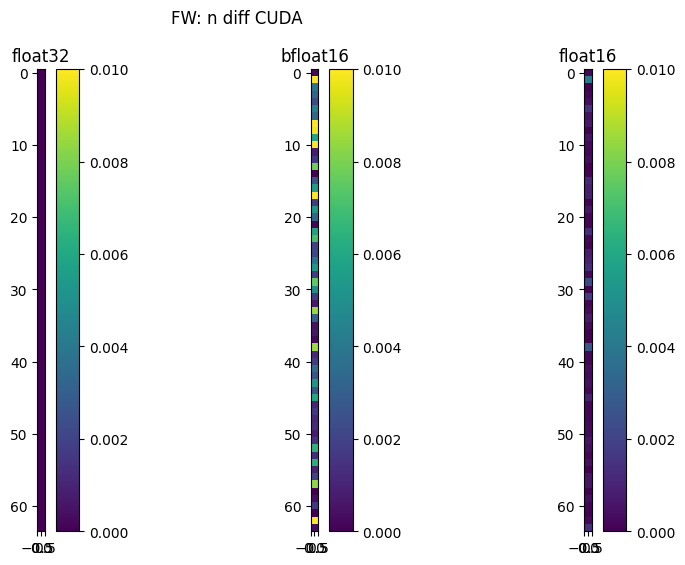

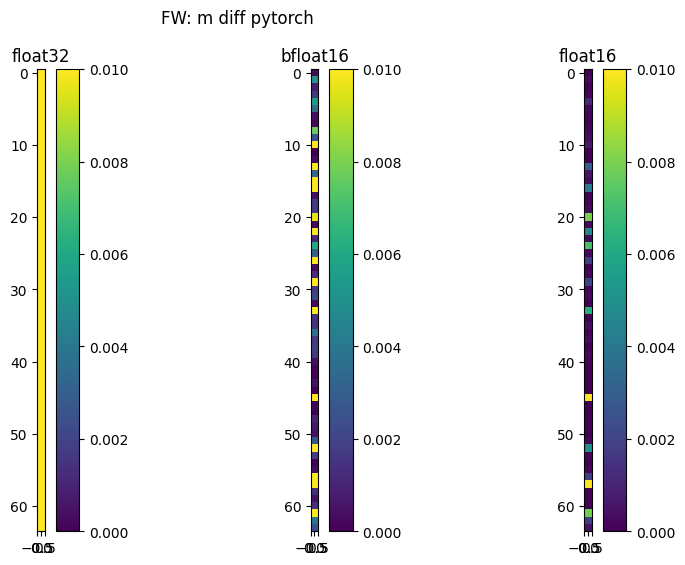

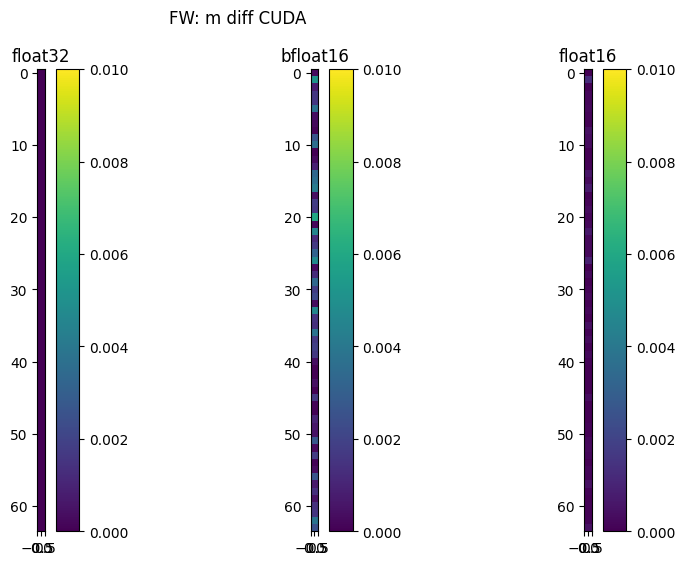

In [27]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

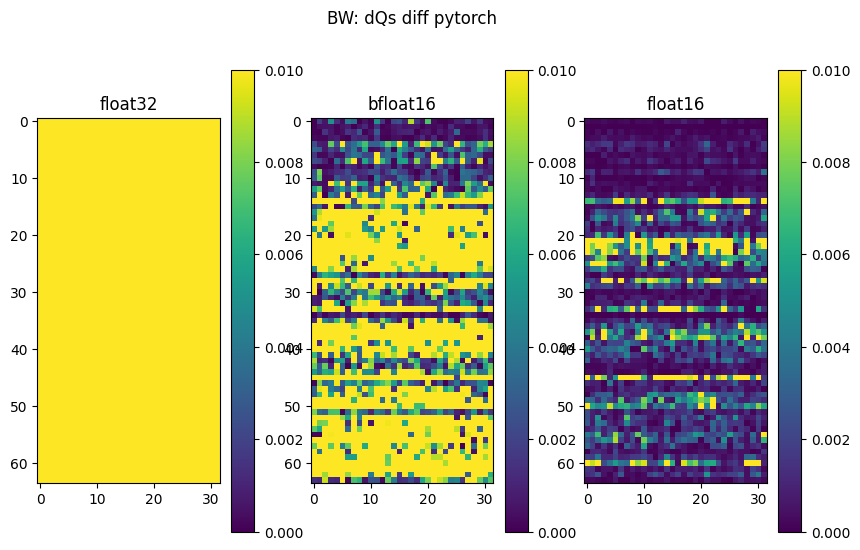

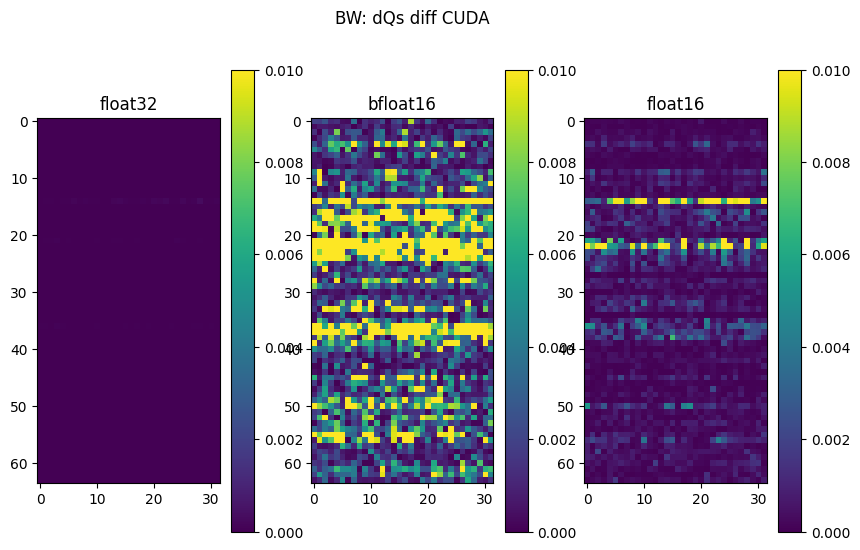

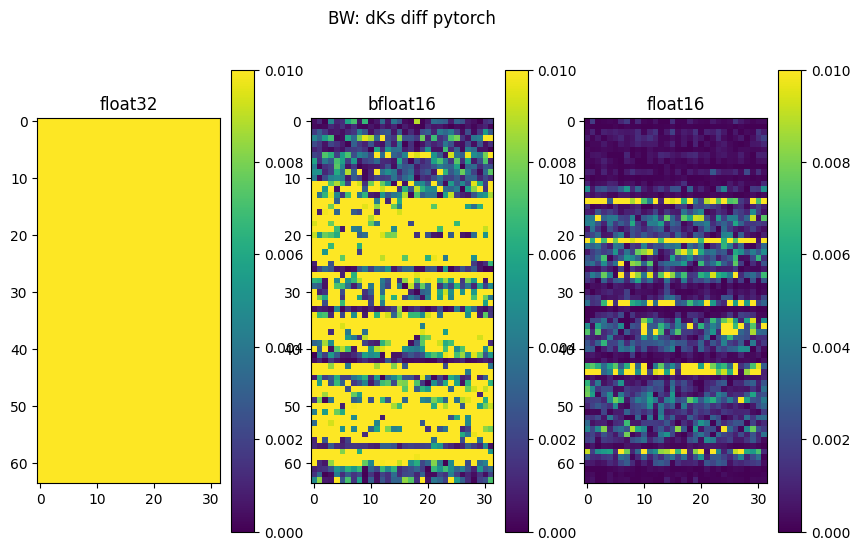

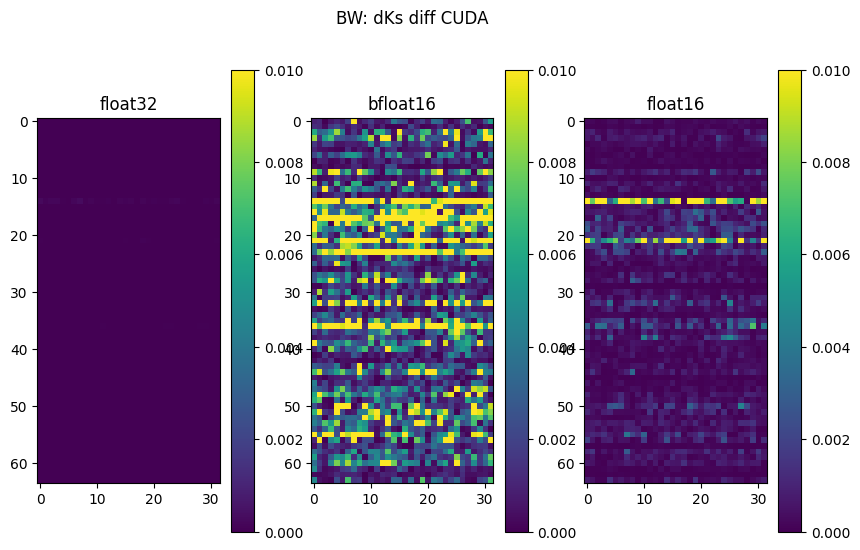

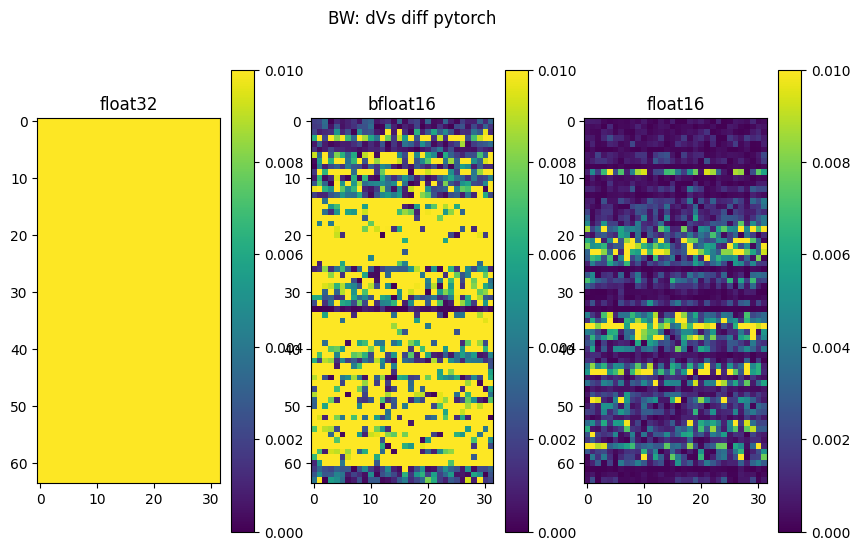

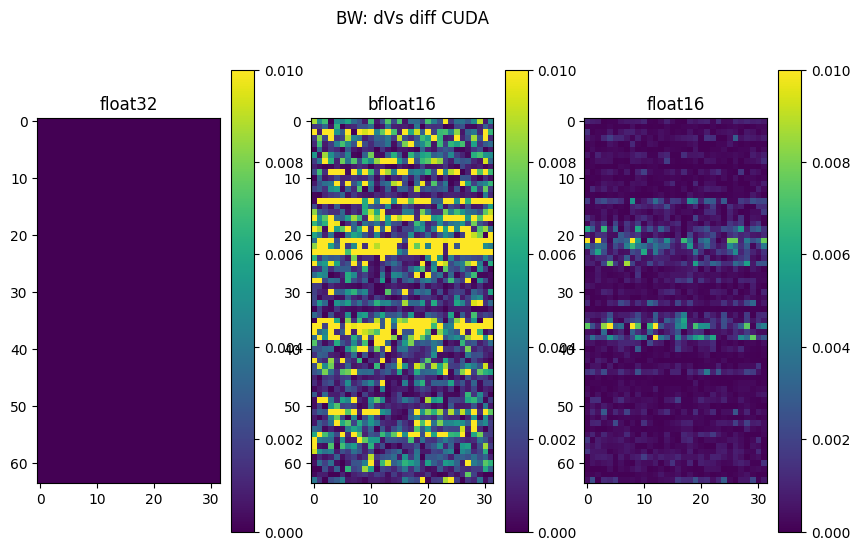

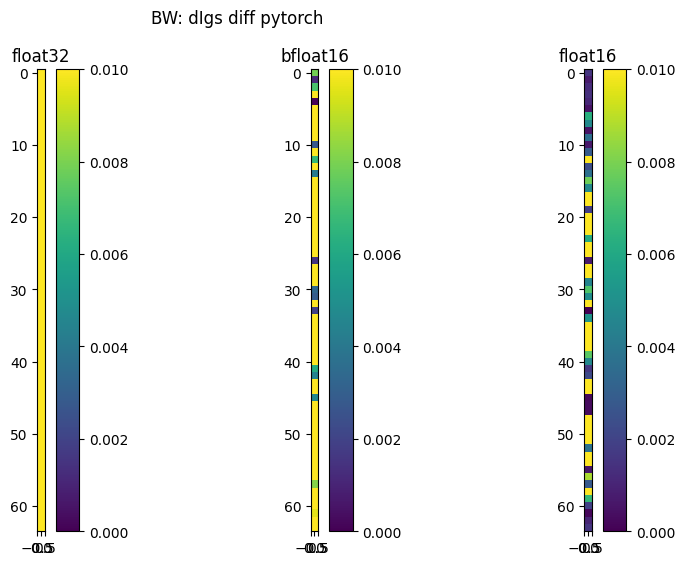

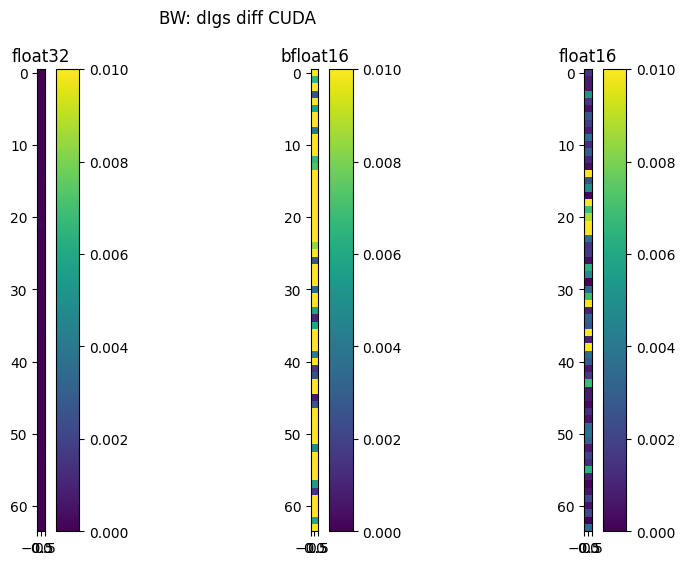

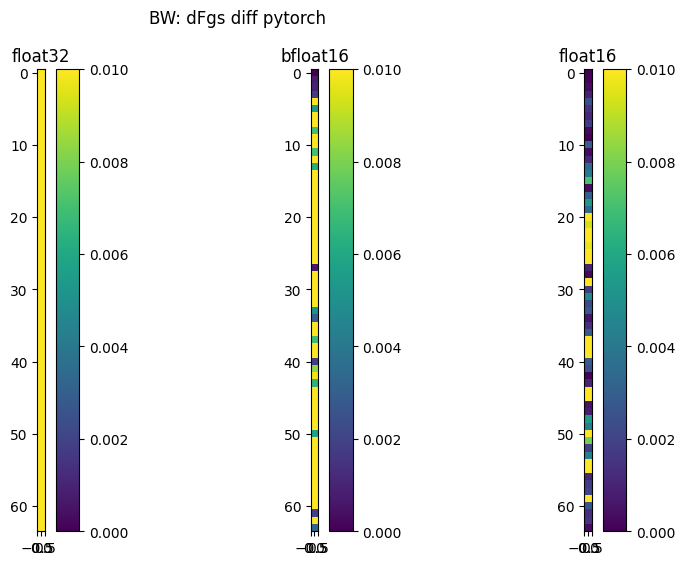

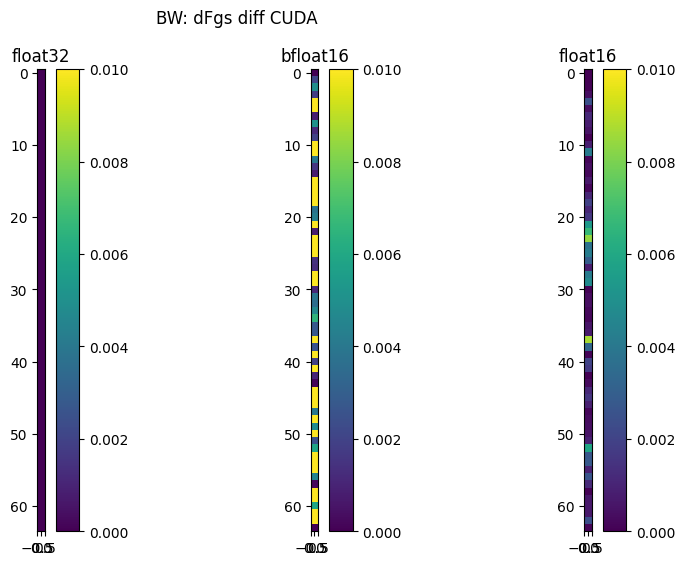

In [28]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [29]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 33408
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [30]:
fgs

tensor([[[[-1.4286],
          [-1.0874],
          [ 0.5559],
          [ 1.0172],
          [-0.3479],
          [-1.3633],
          [-1.3168],
          [ 0.9415],
          [ 0.5776],
          [-0.4001],
          [-0.4550],
          [-0.5947],
          [-2.3788],
          [ 0.0537],
          [ 0.5271],
          [-0.2673],
          [ 0.1509],
          [ 0.3151],
          [-0.8073],
          [ 0.9548],
          [-0.7206],
          [ 0.2526],
          [ 0.8241],
          [-0.6592],
          [ 0.7642],
          [ 0.0181],
          [-0.6598],
          [ 0.6114],
          [ 0.2609],
          [-0.6826],
          [-0.8559],
          [-1.3082],
          [ 0.6555],
          [ 1.0994],
          [-3.3065],
          [ 1.0477],
          [ 1.7495],
          [ 0.0810],
          [-0.4557],
          [-1.1311],
          [-0.1796],
          [-1.4650],
          [ 0.1618],
          [-1.5969],
          [-0.5634],
          [ 0.1197],
          [ 0.1743],
          [-0

In [31]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 17024
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [32]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: 0.012780904769897461
fw n match: False, max diff: 0.00409388542175293
fw m match: False, max diff: 0.0012853145599365234
fw D match: False, max diff: 1.359375


In [33]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [34]:
# (matD_cu_half - matS)[:, :, :, :10]

In [35]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-1.6436],
          [-1.3779],
          [-0.4531],
          [-0.3086],
          [-0.8823],
          [-1.5908],
          [-1.5537],
          [-0.3293],
          [-0.4456],
          [-0.9131],
          [-0.9463],
          [-1.0342],
          [-2.4668],
          [-0.6665],
          [-0.4641],
          [-0.8359],
          [-0.6206],
          [-0.5479],
          [-1.1758],
          [-0.3257],
          [-1.1172],
          [-0.5747],
          [-0.3638],
          [-1.0762],
          [-0.3823],
          [-0.6841],
          [-1.0762],
          [-0.4336],
          [-0.5713],
          [-1.0918],
          [-1.2100],
          [-1.5479],
          [-0.4182],
          [-0.2874],
          [-3.3418],
          [-0.3005],
          [-0.1603],
          [-0.6533],
          [-0.9468],
          [-1.4102],
          [-0.7871],
          [-1.6729],
          [-0.6157],
          [-1.7812],
          [-1.0137],
          [-0.6353],
          [-0.6099],
          [-0

In [36]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-1.6434],
          [-1.3779],
          [-0.4533],
          [-0.3087],
          [-0.8822],
          [-1.5911],
          [-1.5542],
          [-0.3293],
          [-0.4455],
          [-0.9131],
          [-0.9463],
          [-1.0341],
          [-2.4675],
          [-0.6667],
          [-0.4639],
          [-0.8357],
          [-0.6205],
          [-0.5480],
          [-1.1761],
          [-0.3256],
          [-1.1170],
          [-0.5748],
          [-0.3637],
          [-1.0761],
          [-0.3823],
          [-0.6841],
          [-1.0765],
          [-0.4335],
          [-0.5712],
          [-1.0916],
          [-1.2100],
          [-1.5475],
          [-0.4182],
          [-0.2875],
          [-3.3424],
          [-0.3007],
          [-0.1603],
          [-0.6534],
          [-0.9467],
          [-1.4108],
          [-0.7870],
          [-1.6729],
          [-0.6155],
          [-1.7813],
          [-1.0140],
          [-0.6351],
          [-0.6098],
          [-0

In [37]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[ 1.6956e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.2070e+00, -1.2969e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.6602e+00, -1.7500e+00,  3.1519e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-1.9688e+00, -2.0586e+00,  6.8359e-03,  9.1943e-01,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-2.8516e+00, -2.9395e+00, -8.7500e-01,  3.7598e-02, -1.8530e-01,        -inf,        -inf,        -inf,        -inf,        -inf],
           [-4.4414e+00, -4.5312e+00, -2.4648e+00, -1.5527e+00, -1.7764e+00, -1.0898e+00,        -inf,        -inf,        -inf,        -inf],
           [-5.9961e+00, -6.0859e+00, -4.0195e+00, -3.1074e+00, -3.3301e+00, -2.6445e+00, -2.6318e-01,        -inf,        -inf,        -inf],

### debug fw hs nans in last timesteps

In [38]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 33408
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [39]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 17024
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [40]:
hs_cu_half[:, :, 20:30, :10]

tensor([[[[ 7.1094e-01, -9.2432e-01,  7.5244e-01,  1.1357e+00, -1.3125e+00, -2.0664e+00,  8.3301e-01, -2.4551e+00,  3.8086e-02,  4.0955e-02],
          [-1.5059e+00, -1.0156e+00,  1.2373e+00, -1.8809e+00, -9.6533e-01,  2.5605e+00, -6.0547e-01,  3.1582e+00,  5.1689e-03,  1.4160e+00],
          [ 4.8975e-01,  1.6250e+00, -3.6797e+00,  2.1445e+00,  2.3066e+00, -2.2344e+00,  3.9551e-02, -1.7148e+00, -4.8828e-01, -1.0439e+00],
          [-2.0625e+00, -4.1914e+00, -2.1621e+00, -5.9336e+00, -1.4531e+00,  5.5469e+00, -1.5244e+00,  4.4062e+00,  3.0605e+00,  1.8223e+00],
          [ 3.5034e-01, -1.0088e+00,  2.7500e+00, -1.6807e+00, -1.6357e+00,  1.2354e+00, -8.5693e-02,  1.4561e+00,  5.9180e-01,  1.2822e+00],
          [-3.4805e+00,  1.9600e+00, -1.8896e+00,  6.5137e-01,  2.6074e+00,  7.8516e-01, -1.3599e-01,  1.3350e+00, -1.1768e+00,  1.5791e+00],
          [ 8.4717e-01,  1.3496e-02, -1.4541e+00,  4.3921e-01, -6.3538e-02, -4.5508e-01,  2.6953e-01, -1.0654e+00,  1.5540e-01, -8.6523e-01],
      

In [41]:
n_cu[:, :, 120:]

tensor([], device='cuda:0', size=(1, 1, 0, 1))

In [42]:
(hs_cu-hs_pt)[:, :, 120:, :10]

tensor([], device='cuda:0', size=(1, 1, 0, 10))

In [43]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.719329833984375e-05
fw n match: True, max diff: 9.417533874511719e-06
fw m match: True, max diff: 4.5299530029296875e-06
fw D match: False, max diff: 1.3591573238372803


### debug fw hs for Q64xKV64

**Not working:** Possible reason for Q64xKV64 we use too much shared memory than available on the the laptop gpu.

In [44]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 33408
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [45]:
(hs_cu - hs_pt)[:,:, :10, :10] 

tensor([[[[-2.9802e-08, -5.2154e-08,  4.4703e-08,  1.4901e-08,  2.6077e-08,  3.7253e-08, -3.7253e-08,  8.9407e-08,  9.3132e-09,  1.3039e-08],
          [-1.4901e-08,  2.9802e-08, -1.1921e-07,  2.9802e-08,  4.4703e-08, -5.9605e-08,  1.1921e-07, -1.4901e-08,  5.9605e-08, -8.9407e-08],
          [ 0.0000e+00, -7.4506e-09,  2.9802e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9802e-08,  0.0000e+00,  0.0000e+00],
          [-4.4703e-08,  0.0000e+00, -1.1921e-07, -2.3842e-07, -2.3842e-07,  1.1921e-07,  2.3842e-07,  0.0000e+00, -1.1921e-07, -2.9802e-08],
          [-1.1921e-07, -9.5367e-07, -4.7684e-07, -5.9605e-08,  4.3772e-08,  3.5763e-07,  3.5763e-07,  4.7684e-07, -1.7881e-07, -1.1921e-07],
          [-1.4901e-08,  0.0000e+00,  2.9802e-08,  2.9802e-08, -2.2352e-08, -5.9605e-08, -2.9802e-08, -5.2154e-08, -8.9407e-08,  0.0000e+00],
          [-1.4901e-08,  1.1921e-07,  5.2154e-08, -1.4901e-08, -5.9605e-08,  5.9605e-08,  5.9605e-08, -1.4901e-07, -1.0431e-07,  5.9605e-08],
      

In [46]:
(hs_cu)[:,:, :8, :10] 

tensor([[[[ 0.0662,  0.1164, -0.0949, -0.0369, -0.0543, -0.0849,  0.0664, -0.2108, -0.0232, -0.0275],
          [ 0.1011, -0.1352,  0.6614, -0.1213, -0.2187,  0.1955, -0.4856,  0.1892, -0.2480,  0.3506],
          [ 0.2149,  0.0476,  0.4171,  2.0345,  2.1339, -0.5256, -1.2907, -0.4263,  0.4714,  0.2461],
          [-0.0800, -2.0850, -1.8355, -1.1837,  0.1024,  1.3610,  1.7972,  2.9755,  1.1028, -0.4684],
          [ 0.6126,  3.6316,  1.8998,  0.3644,  0.0037, -0.8326, -1.0056, -3.5250,  0.7319,  0.6287],
          [ 0.0336,  0.1353, -0.3010, -0.4251,  0.1067,  0.5722,  0.3286,  0.0730,  0.1241,  0.1140],
          [-0.2137, -0.2766, -0.0816, -0.2077,  0.5795, -0.4050, -0.6026,  0.3682, -0.0317, -0.4180],
          [-0.2922, -2.8473,  0.8812, -1.5637, -2.0510, -0.7217, -0.4277,  0.5156, -0.6132, -0.5318]]]], device='cuda:0')

In [47]:
(hs_pt)[:,:, :8, :10] 

tensor([[[[ 0.0662,  0.1164, -0.0949, -0.0369, -0.0543, -0.0849,  0.0664, -0.2108, -0.0232, -0.0275],
          [ 0.1011, -0.1352,  0.6614, -0.1213, -0.2187,  0.1955, -0.4856,  0.1892, -0.2480,  0.3506],
          [ 0.2149,  0.0476,  0.4171,  2.0345,  2.1339, -0.5256, -1.2907, -0.4263,  0.4714,  0.2461],
          [-0.0800, -2.0850, -1.8355, -1.1837,  0.1024,  1.3610,  1.7972,  2.9755,  1.1028, -0.4684],
          [ 0.6126,  3.6316,  1.8998,  0.3644,  0.0037, -0.8326, -1.0056, -3.5250,  0.7319,  0.6287],
          [ 0.0336,  0.1353, -0.3010, -0.4251,  0.1067,  0.5722,  0.3286,  0.0730,  0.1241,  0.1140],
          [-0.2137, -0.2766, -0.0816, -0.2077,  0.5795, -0.4050, -0.6026,  0.3682, -0.0317, -0.4180],
          [-0.2922, -2.8473,  0.8812, -1.5637, -2.0510, -0.7217, -0.4277,  0.5156, -0.6132, -0.5318]]]], device='cuda:0')

In [48]:
(matD_cu - matD_pt)[:,:, :10, :10] 

tensor([[[[-0.8304,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.2083, -2.2121,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-1.8001, -1.8767, -0.6847,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.0259, -2.1095, -0.3947, -0.0804,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-2.9081, -2.9917, -1.2769, -0.9626, -0.9856,    -inf,    -inf,    -inf,    -inf,    -inf],
          [-4.4785, -4.5638, -2.7190, -2.1824, -2.2796, -2.0896,    -inf,    -inf,    -inf,    -inf],
          [-6.0010, -6.0890, -4.0442, -3.1660, -3.3771, -2.7364, -1.2633,    -inf,    -inf,    -inf],
          [-6.3283, -6.4165, -4.3590, -3.4591, -3.6775, -3.0080, -0.9696, -0.6170,    -inf,    -inf],
          [-6.7738, -6.8620, -4.8045, -3.9046, -4.1229, -3.4535, -1.4151, -1.0625, -1.2006,    -inf],
          [-7.6857, -7.7740, -5.7095, -4.7977, -5.0200, -4.3349, -1.9853, -1.0660,

In [49]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.719329833984375e-05
fw n match: True, max diff: 9.417533874511719e-06
fw m match: True, max diff: 4.5299530029296875e-06
fw D match: False, max diff: 1.3591573238372803


In [50]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -4.3637e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 5.0411e-05,  3.8266e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.8959e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.3111e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00, -1.0080e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.6937e-05,  1.9595e-05,  6.0183e-04,  2.0962e-03,  6.9177e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.3574e-07, -4.9016e-06,  3.6132e-05,  2.8056e-04,  5.2996e-05, -3.1762e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [51]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [52]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

### debug q16xkv16 tile size backward

In [53]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_C_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [54]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 33408
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In FW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16
before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 32
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 55168
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 16, bdim.y: 16
In BW-Kernel: QtileDim: 32, KVtileDim: 32, TblockDim:16


In [55]:
# mat_P_pt[:, :, :16, :9]

In [56]:
# mat_R_pt[:, :, :16, :9]

In [57]:
delta_C_pt[:, :, :16, :9]

tensor([[[[ 3.6603e+00, -3.6564e+00,  8.7304e+00,  9.7454e+00, -7.6454e+00,  7.5035e+00,  5.2817e+00,  1.9204e+00,  9.5010e+00],
          [ 2.8838e-01, -2.9151e-02, -7.1263e-01,  1.6605e-01,  1.6778e+00, -7.9380e-01,  3.8582e+00,  1.0825e-01,  1.0936e+00],
          [-3.4923e+00,  4.8771e+00, -3.1702e+00,  2.9198e+00,  1.5227e+01, -1.4074e+01,  1.8535e+00, -1.8780e+00,  1.9614e+00],
          [-1.8163e+00,  1.1249e+01,  1.0939e+00,  2.8987e-01,  1.2630e+01, -1.1553e+01,  7.7004e+00,  1.0698e+01,  1.0951e+01],
          [-1.8476e+00,  2.7655e-01,  6.1334e+00, -4.8701e+00,  1.2727e+00, -8.9462e+00,  2.9786e-01,  4.1855e-03, -4.7773e+00],
          [ 2.4242e-01,  1.3981e+00, -2.6908e+00,  1.8937e+00, -4.3918e+00, -1.6199e+00, -8.9162e-01,  3.2340e+00,  3.4577e+00],
          [-2.6691e+00,  1.1057e+01, -5.8557e+00, -6.1066e+00, -7.9840e+00, -7.8367e+00, -1.9328e+00, -1.5803e+00, -4.5958e+00],
          [-1.0390e+00, -1.2785e+00, -8.0685e-01,  1.7396e+00,  4.0968e-01, -2.9453e+00,  2.7662e

In [58]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)
matS[:,:, :16, :9], (matC_cu-matS).abs().max() #(matC_cu-matS)[:,:,:16,:9]

(tensor([[[[-0.0961, -1.8711,  0.9341, -1.3155, -0.9150, -0.4050, -0.7507,  1.6704, -1.1101],
           [ 0.6510,  0.9283, -0.6924,  1.2197,  2.2210,  0.3152, -1.7155,  0.0756, -1.8405],
           [-0.2012, -0.8635,  0.9225,  0.7662, -0.7581, -1.7819,  0.9815, -0.8251,  1.2308],
           [ 1.5852, -0.6699, -0.7249,  0.9823, -0.8449, -1.0497,  1.2888, -0.3716,  1.6619],
           [-0.7649,  1.2462, -0.2735, -1.1995,  1.0055, -1.1140, -0.1066,  0.7551,  0.1469],
           [ 1.4173, -0.1924, -0.4866,  0.2352,  0.8274, -0.7731,  0.8315,  0.1133,  0.5467],
           [ 0.4663,  0.2220,  0.2428,  2.3131, -0.2464,  1.5706, -0.5495, -0.2174,  0.1944],
           [-1.1484, -1.6549, -0.2404, -0.5273, -1.5675, -1.0082, -1.4876,  2.6845, -1.2404],
           [-0.4970, -1.5021, -0.1295,  0.3962, -0.3559,  0.6643, -0.8605, -0.9321, -0.8378],
           [ 0.5130,  0.7713,  0.0527, -0.4008, -0.4361, -0.3165,  0.3729,  0.3070,  1.2066],
           [-0.6069, -0.1790,  2.2517, -0.3118,  1.2299, -0.

In [59]:
matD_pt[:, :, :16, :9]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1548e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3850e-01, 1.2679e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 8.0032e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4947e-02, 3.1993e-02, 2.5233e-01, 6.2876e-01, 5.0321e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2326e-03, 2.9594e-03, 2.3340e-02, 5.8161e-02, 4.6547e-02, 9.2500e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.7981e-03, 2.1923e-02, 1.7546e-02, 3.4868e-02, 3.7695e-01, 1.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.798

In [60]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 3.719329833984375e-05
fw n match: True, max diff: 9.417533874511719e-06
fw m match: True, max diff: 4.5299530029296875e-06
fw D match: True, max diff: 7.62939453125e-06
---------------------------------
bw dQs match: True, max diff: 0.00028228759765625
bw dKs match: True, max diff: 0.000301361083984375
bw dVs match: True, max diff: 3.7670135498046875e-05
bw dIgs match: True, max diff: 0.00012230873107910156
bw dFgs match: True, max diff: 2.86102294921875e-05


In [61]:
# dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt

In [62]:
mat_P_pt[:, :, -20:, :10]

tensor([[[[ 2.7463e-18, -8.5720e-19, -2.6009e-17,  4.1752e-18,  4.3884e-17,  4.0661e-16,  5.7401e-15, -4.8072e-15, -3.6340e-15,  1.2705e-13],
          [ 1.1068e-18, -1.3559e-17,  5.3999e-17, -8.4296e-17,  9.9960e-17,  2.7113e-16, -2.5396e-15, -7.7646e-15, -4.4406e-15,  9.1843e-14],
          [-1.0132e-18, -2.6356e-18,  2.0049e-17,  2.2228e-17,  4.8618e-18, -9.5610e-17, -8.3504e-16, -7.3080e-17, -3.1153e-16,  5.7770e-14],
          [-2.8754e-18, -5.3794e-19,  2.3565e-18,  5.9709e-18, -4.8258e-17,  1.0231e-16, -7.3685e-16, -8.6054e-16,  6.7427e-16,  1.6780e-14],
          [-4.4428e-19, -6.9327e-20,  2.0455e-18, -8.7861e-19,  2.1926e-19, -2.9577e-18,  4.0196e-17, -4.5066e-16,  1.6657e-16,  8.1184e-15],
          [-1.6966e-19, -8.9112e-20,  1.4419e-18,  1.1297e-18,  5.3064e-18,  1.0375e-17, -7.6938e-18,  3.2417e-16, -3.0423e-16, -3.4842e-15],
          [-3.9638e-19,  9.8144e-21,  1.7000e-18, -9.1232e-18, -5.5753e-18, -3.2432e-18, -1.2616e-16, -2.1974e-17,  1.6658e-16, -3.7552e-16],
      

In [63]:
matC_cu[:, :, -20:, :10]

tensor([[[[-0.6877, -2.0965,  1.2441,  0.0359, -0.3232, -0.5932, -0.4679, -0.6703, -0.0656, -0.4100],
          [-0.5135, -1.1535, -0.1135, -2.2100, -0.0846, -0.0616, -2.2588,  2.0486, -1.1432,  0.1260],
          [ 0.9300, -0.5651,  0.5751, -1.2746,  0.8396, -0.6333, -0.4888,  2.0546,  0.5618,  0.5109],
          [-0.1807,  0.3847, -0.1052,  0.8795, -0.2628,  0.3297, -0.3986,  1.6523, -0.4827, -0.2269],
          [-0.1818,  0.0404,  0.3782,  0.3252, -2.4570, -0.1081, -0.7063, -0.7807, -0.3927, -0.1813],
          [-0.5992,  0.0260, -0.1434, -0.4277,  0.1408,  0.2964, -0.5709,  1.3931, -1.1954, -1.2372],
          [ 0.6676, -0.0213, -0.0308, -0.0787, -0.1432,  0.3535,  0.7648, -0.3114, -0.1197,  0.3300],
          [-1.6429, -2.3586,  0.6586, -0.3089, -1.0932, -2.2504,  2.5881,  0.1969,  0.9509, -0.4021],
          [-0.6192, -0.7161,  0.2237, -0.1875, -0.4132,  0.8746, -0.3090,  1.2639, -0.5782, -0.7646],
          [-0.2329,  1.3644, -0.6485,  1.2033,  0.1162,  0.9100, -1.9240,  0.1695,

In [64]:
(matC_cu-mat_P_pt)[:, :, -20:, :10], torch.abs((matC_cu-mat_P_pt)).max()

(tensor([[[[-0.6877, -2.0965,  1.2441,  0.0359, -0.3232, -0.5932, -0.4679, -0.6703, -0.0656, -0.4100],
           [-0.5135, -1.1535, -0.1135, -2.2100, -0.0846, -0.0616, -2.2588,  2.0486, -1.1432,  0.1260],
           [ 0.9300, -0.5651,  0.5751, -1.2746,  0.8396, -0.6333, -0.4888,  2.0546,  0.5618,  0.5109],
           [-0.1807,  0.3847, -0.1052,  0.8795, -0.2628,  0.3297, -0.3986,  1.6523, -0.4827, -0.2269],
           [-0.1818,  0.0404,  0.3782,  0.3252, -2.4570, -0.1081, -0.7063, -0.7807, -0.3927, -0.1813],
           [-0.5992,  0.0260, -0.1434, -0.4277,  0.1408,  0.2964, -0.5709,  1.3931, -1.1954, -1.2372],
           [ 0.6676, -0.0213, -0.0308, -0.0787, -0.1432,  0.3535,  0.7648, -0.3114, -0.1197,  0.3300],
           [-1.6429, -2.3586,  0.6586, -0.3089, -1.0932, -2.2504,  2.5881,  0.1969,  0.9509, -0.4021],
           [-0.6192, -0.7161,  0.2237, -0.1875, -0.4132,  0.8746, -0.3090,  1.2639, -0.5782, -0.7646],
           [-0.2329,  1.3644, -0.6485,  1.2033,  0.1162,  0.9100, -1.9240

In [65]:
(matC_cu-mat_R_pt)[:, :, -20:, :10], torch.abs((matC_cu-mat_R_pt)).max()

(tensor([[[[-0.6877, -2.0965,  1.2441,  0.0359, -0.3232, -0.5932, -0.4679, -0.6703, -0.0656, -0.4100],
           [-0.5135, -1.1535, -0.1135, -2.2100, -0.0846, -0.0616, -2.2588,  2.0486, -1.1432,  0.1260],
           [ 0.9300, -0.5651,  0.5751, -1.2746,  0.8396, -0.6333, -0.4888,  2.0546,  0.5618,  0.5109],
           [-0.1807,  0.3847, -0.1052,  0.8795, -0.2628,  0.3297, -0.3986,  1.6523, -0.4827, -0.2269],
           [-0.1818,  0.0404,  0.3782,  0.3252, -2.4570, -0.1081, -0.7063, -0.7807, -0.3927, -0.1813],
           [-0.5992,  0.0260, -0.1434, -0.4277,  0.1408,  0.2964, -0.5709,  1.3931, -1.1954, -1.2372],
           [ 0.6676, -0.0213, -0.0308, -0.0787, -0.1432,  0.3535,  0.7648, -0.3114, -0.1197,  0.3300],
           [-1.6429, -2.3586,  0.6586, -0.3089, -1.0932, -2.2504,  2.5881,  0.1969,  0.9509, -0.4021],
           [-0.6192, -0.7161,  0.2237, -0.1875, -0.4132,  0.8746, -0.3090,  1.2639, -0.5782, -0.7646],
           [-0.2329,  1.3644, -0.6485,  1.2033,  0.1162,  0.9100, -1.9240

In [66]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)

In [67]:
(matC_cu-matS)[:, :, -20:, :10], torch.abs((matC_cu-matS)).max()

(tensor([[[[ 5.9605e-08,  0.0000e+00, -1.1921e-07, -3.7253e-09,  2.9802e-08,  5.9605e-08,  2.9802e-08,  5.9605e-08,  7.4506e-09,  2.9802e-08],
           [ 5.9605e-08,  1.1921e-07,  7.4506e-09,  2.3842e-07,  7.4506e-09,  3.7253e-09,  0.0000e+00,  0.0000e+00,  1.1921e-07, -1.4901e-08],
           [-5.9605e-08,  5.9605e-08, -5.9605e-08,  1.1921e-07, -5.9605e-08,  5.9605e-08,  5.9605e-08, -2.3842e-07, -5.9605e-08,  0.0000e+00],
           [ 1.4901e-08, -2.9802e-08,  7.4506e-09, -5.9605e-08,  2.9802e-08, -2.9802e-08,  2.9802e-08, -2.3842e-07,  2.9802e-08,  1.4901e-08],
           [ 1.4901e-08, -3.7253e-09, -2.9802e-08, -2.9802e-08,  0.0000e+00,  7.4506e-09,  5.9605e-08,  5.9605e-08,  2.9802e-08,  1.4901e-08],
           [ 5.9605e-08, -1.8626e-09,  1.4901e-08,  2.9802e-08, -1.4901e-08, -2.9802e-08,  5.9605e-08, -1.1921e-07,  0.0000e+00,  1.1921e-07],
           [-5.9605e-08,  1.8626e-09,  3.7253e-09,  7.4506e-09,  1.4901e-08, -2.9802e-08, -5.9605e-08,  2.9802e-08,  1.4901e-08, -2.9802e-08],

In [68]:
(matC_cu-delta_Dtilde_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_Dtilde_pt)).max()

(tensor([[[[-0.6877, -2.0965,  1.2441,  0.0359, -0.3232, -0.5932, -0.4679, -0.6703, -0.0656, -0.4100],
           [-0.5135, -1.1535, -0.1135, -2.2100, -0.0846, -0.0616, -2.2588,  2.0486, -1.1432,  0.1260],
           [ 0.9300, -0.5651,  0.5751, -1.2746,  0.8396, -0.6333, -0.4888,  2.0546,  0.5618,  0.5109],
           [-0.1807,  0.3847, -0.1052,  0.8795, -0.2628,  0.3297, -0.3986,  1.6523, -0.4827, -0.2269],
           [-0.1818,  0.0404,  0.3782,  0.3252, -2.4570, -0.1081, -0.7063, -0.7807, -0.3927, -0.1813],
           [-0.5992,  0.0260, -0.1434, -0.4277,  0.1408,  0.2964, -0.5709,  1.3931, -1.1954, -1.2372],
           [ 0.6676, -0.0213, -0.0308, -0.0787, -0.1432,  0.3535,  0.7648, -0.3114, -0.1197,  0.3300],
           [-1.6429, -2.3586,  0.6586, -0.3089, -1.0932, -2.2504,  2.5881,  0.1969,  0.9509, -0.4021],
           [-0.6192, -0.7161,  0.2237, -0.1875, -0.4132,  0.8746, -0.3090,  1.2639, -0.5782, -0.7646],
           [-0.2329,  1.3644, -0.6485,  1.2033,  0.1162,  0.9100, -1.9240

In [69]:
(matC_cu-delta_D_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_D_pt)).max()

(tensor([[[[ 6.9986e-02, -2.8841e+00,  3.0420e+00,  3.2590e-02,  7.1989e-02,  2.7885e+00,  3.0152e+00, -2.2457e+00, -2.7277e-01,  1.8942e+00],
           [-2.8548e-01, -8.0072e+00,  2.2705e-01, -6.3643e+00,  1.5110e-01,  1.7258e-01, -9.6986e+00,  9.8246e+00, -5.5584e+00, -3.8580e-01],
           [ 2.0146e+00, -2.4380e+00, -1.2633e+00,  5.3815e-01,  5.1328e-01, -3.0693e+00, -2.0077e+00,  2.2652e+00,  9.9862e-01, -3.2352e+00],
           [-1.3485e+00,  8.9263e-01, -2.8030e-02,  2.2355e-01, -2.2424e+00, -2.3195e+00, -2.5325e+00,  5.5459e+00,  1.1030e+00,  7.1635e-01],
           [-6.3067e-01,  5.7326e-02, -2.1705e-01,  4.1344e-01, -2.2491e+00, -1.7016e-01, -1.9644e-01, -3.1624e+00,  3.9503e-01,  7.2044e-01],
           [-1.6090e+00,  5.1187e-02,  1.4111e-01, -1.6092e-01, -3.7476e-01, -7.7139e-01, -7.1191e-01, -4.0735e+00, -9.0273e+00, -5.9587e+00],
           [ 9.2235e+00, -1.3946e-02,  2.0350e-01, -1.3693e+00, -1.9362e+00,  1.6486e+00,  1.0849e+01, -5.8105e-01,  1.2783e+00,  7.7182e-01],

In [70]:
(matC_cu-matD_pt)[:, :, :20, :10]

tensor([[[[-1.0961, -1.8711,  0.9341, -1.3155, -0.9150, -0.4050, -0.7507,  1.6704, -1.1101, -0.4790],
          [-0.3490,  0.0128, -0.6924,  1.2197,  2.2210,  0.3152, -1.7155,  0.0756, -1.8405,  0.3306],
          [-0.3397, -0.9903, -0.0775,  0.7662, -0.7581, -1.7819,  0.9815, -0.8251,  1.2308,  0.7307],
          [ 1.5296, -0.7208, -1.1262, -0.0177, -0.8449, -1.0497,  1.2888, -0.3716,  1.6619, -1.0586],
          [-0.8205,  1.1953, -0.6748, -2.1995,  0.2052, -1.1140, -0.1066,  0.7551,  0.1469,  0.9564],
          [ 1.3824, -0.2244, -0.7389, -0.3935,  0.3242, -1.7731,  0.8315,  0.1133,  0.5467, -1.3158],
          [ 0.4630,  0.2191,  0.2195,  2.2550, -0.2929,  1.4781, -1.5495, -0.2174,  0.1944,  0.3227],
          [-1.1496, -1.6560, -0.2492, -0.5493, -1.5851, -1.0431, -1.8645,  1.6845, -1.2404, -1.2537],
          [-0.4982, -1.5032, -0.1383,  0.3742, -0.3735,  0.6294, -1.2374, -1.9321, -1.3999, -2.1258],
          [ 0.5129,  0.7712,  0.0519, -0.4028, -0.4377, -0.3196,  0.3388,  0.2165,

In [71]:
(dQs_cu - dQs_pt)[:,:,:10, :10]

tensor([[[[-4.4703e-07, -4.7684e-07, -5.0664e-07, -1.0729e-06,  3.2783e-07, -4.4703e-07, -6.5565e-07, -6.5565e-07, -2.7940e-09, -3.2783e-07],
          [ 5.5879e-09,  0.0000e+00,  3.7253e-09,  0.0000e+00,  0.0000e+00,  3.7253e-09,  3.7253e-09,  3.7253e-09, -4.6566e-10,  3.7253e-09],
          [-1.8626e-07,  1.1921e-07,  1.1921e-06, -3.6089e-08,  1.1325e-06,  1.7881e-07,  8.3447e-07, -6.5565e-07, -6.5565e-07,  6.5565e-07],
          [ 3.7253e-08, -6.9849e-09, -1.4901e-08, -2.9802e-07, -1.6391e-07,  4.6566e-08, -6.5193e-09, -2.0862e-07,  4.7684e-07,  2.2352e-07],
          [-4.7684e-07,  6.5565e-07, -4.7684e-07,  1.3113e-06, -5.3644e-07,  5.3644e-07,  3.8743e-07,  8.3447e-07, -5.9605e-07,  4.7684e-07],
          [ 2.0862e-07, -8.9407e-08,  8.9407e-08,  2.9802e-08,  1.1921e-07,  1.4901e-08, -2.0862e-07, -1.7881e-07, -1.4901e-07, -1.1921e-07],
          [ 2.6077e-08,  3.3528e-08,  1.8626e-09,  3.3528e-08, -2.9802e-08,  1.4901e-08, -1.0431e-07,  2.9802e-07, -2.6822e-07,  5.9605e-08],
      